## Import and install all required packages and libraries

In [30]:
!pip install patchify
!pip install keras
!pip install imagecodecs
!pip install -U scikit-learn==0.24.2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [31]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import os
import re
import cv2

## Multi Unet Model

In [32]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=5, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.summary()
    
    return model

## Train data

In [33]:
train_filenames = []
for subdir, dirs, files in os.walk('./data/train'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            
            train_filenames.append(filepath)
            
train_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
train_filenames = np.array(train_filenames)

all_img_patches = []

for img_file in train_filenames:  
    large_image = tiff.imread(img_file)
    patches_img = patchify(large_image, (128, 128, 3), step=128)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j, 0, :, :, :]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            
            all_img_patches.append(single_patch_img)

train_images = np.array(all_img_patches)

In [34]:
train_mask_filenames = []
for subdir, dirs, files in os.walk('./data/train_mask'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            train_mask_filenames.append(filepath)
            
train_mask_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
train_mask_filenames = np.array(train_mask_filenames)          

all_mask_patches = []

for img_file in train_mask_filenames:  
     
    large_mask = tiff.imread(img_file)  
    patches_mask = patchify(large_mask, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            all_mask_patches.append(single_patch_mask)

train_masks = np.array(all_mask_patches)

In [35]:
print(train_images.shape)
print(train_masks.shape)
print("Pixel values in the mask are: ", np.unique(train_masks))

(3480, 128, 128, 3)
(3480, 128, 128)
Pixel values in the mask are:  [0 1 2 3 4]


In [36]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
print(train_masks.shape)
n, h, w = train_masks.shape

train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

(3480, 128, 128)


array([0, 1, 2, 3, 4])

## Test data

In [37]:
test_filenames = []
for subdir, dirs, files in os.walk('./data/test'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            test_filenames.append(filepath)
            
test_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
test_filenames = np.array(test_filenames)

all_img_patches = []

for img_file in test_filenames:  
    large_image = tiff.imread(img_file)
    #large_image = cv2.imread(img_path, 0)    
    patches_img = patchify(large_image, (128, 128, 3), step=128)
    
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j, 0, :, :, :]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            
            all_img_patches.append(single_patch_img)

test_images = np.array(all_img_patches)

In [38]:
test_mask_filenames = []
for subdir, dirs, files in os.walk('./data/test_mask'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".tiff"):
            test_mask_filenames.append(filepath)
            
test_mask_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))    
test_mask_filenames = np.array(test_mask_filenames)          

all_mask_patches = []

for img_file in test_mask_filenames:  
    large_mask = tiff.imread(img_file)   
    #large_image = cv2.imread(img_path, 0)    
    patches_mask = patchify(large_mask, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            all_mask_patches.append(single_patch_mask)

test_masks = np.array(all_mask_patches)

In [39]:
print(test_images.shape)
print(test_masks.shape)
print("Pixel values in the mask are: ", np.unique(test_masks))

(2280, 128, 128, 3)
(2280, 128, 128)
Pixel values in the mask are:  [0 1 2 3 4]


In [40]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
print(train_masks.shape)
n, h, w = train_masks.shape

train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

(3480, 128, 128)


array([0, 1, 2, 3, 4])

In [41]:
from tensorflow.keras.utils import normalize

print(train_images.shape)
#train_images = np.expand_dims(train_images, axis=3)
print(train_images.shape)

train_images = normalize(train_images, axis=1)
print(train_images.shape)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

print(train_masks_input.shape)

(3480, 128, 128, 3)
(3480, 128, 128, 3)
(3480, 128, 128, 3)
(3480, 128, 128, 1)


In [42]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3 4]


In [43]:
print(X_train.shape)

(2505, 128, 128, 3)


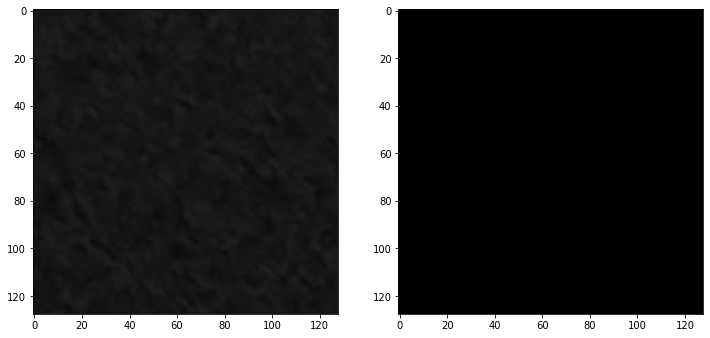

In [44]:
#Sanity check, view few mages
import random
import numpy as np

image_number = random.randint(0, len(X_train))

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')

plt.show()

In [45]:
from tensorflow.keras.utils import to_categorical

n_classes = 5
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
print(y_train_cat.shape)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_test_cat.shape)

(2505, 128, 128, 5)
(348, 128, 128, 5)


In [46]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)

print("Class weights are...:", class_weights)

Class weights are...: [ 0.22325477  6.66665342 59.673897    3.93736819  9.99224859]


In [57]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(X_train.shape)

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(2505, 128, 128, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 16  0           ['conv2d_38[0][0]']              
                                )                                       

 conv2d_53 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_25[0][0]']             
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 128, 128, 16  2064       ['conv2d_53[0][0]']              
 nspose)                        )                                                                 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 128, 128, 32  0           ['conv2d_transpose_11[0][0]',    
                                )                                 'conv2d_39[0][0]']              
                                                                                                  
 conv2d_54 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_11[0][0]']         
                                )                                                                 
          

In [58]:
#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

'''
history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

model.save('test.hdf5')
'''

#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')

"\nhistory = model.fit(X_train, y_train_cat, \n                    batch_size = 8, \n                    verbose=1, \n                    epochs=50, \n                    validation_data=(X_test, y_test_cat), \n                    #class_weight=class_weights,\n                    shuffle=False)\n\nmodel.save('test.hdf5')\n"

In [59]:
model.load_weights('test.hdf5')
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

11/11 [==============================] - 4s 302ms/step - loss: 0.0608 - accuracy: 0.9846
Accuracy is =  98.46368432044983 %


In [60]:
#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:

#IOU
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)


##################################################

#Using built in keras function
from keras.metrics import MeanIoU

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[0,4] + values[1,0]+ values[2,0]+ values[3,0]+values[4,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] +values[1, 4] + values[0,1]+ values[2,1]+ values[3,1] + values[4,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] +values[2, 4] + values[0,2]+ values[1,2]+ values[3,2] + values[4,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] +values[3, 4] + values[0,3]+ values[1,3]+ values[2,3] + values[4,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4, 3] + values[0,4]+ values[1,4]+ values[2,4] + values[4,3])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)

Mean IoU = 0.79687864
[[5.085817e+06 5.011000e+03 1.194000e+03 3.285000e+03 1.764700e+04]
 [1.101400e+04 1.321780e+05 2.260000e+02 1.194000e+03 1.350000e+02]
 [3.449000e+03 2.021000e+03 1.371600e+04 6.410000e+02 0.000000e+00]
 [2.448000e+03 3.930000e+02 1.380000e+02 2.912370e+05 2.099000e+03]
 [2.556000e+03 5.100000e+01 3.900000e+01 3.405400e+04 9.108900e+04]]
IoU for class1 is:  0.9909197
IoU for class2 is:  0.8683182
IoU for class3 is:  0.6402166
IoU for class4 is:  0.868097
IoU for class5 is:  0.5071065


Image number 119
(1, 128, 128, 3)


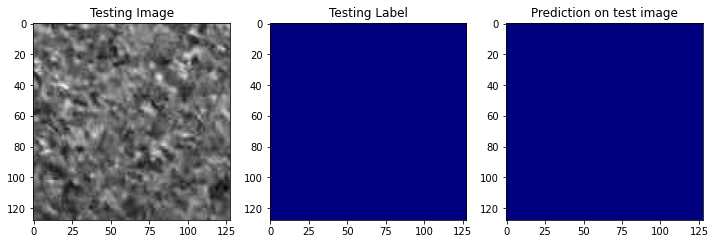

In [153]:
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

print('Image number', test_img_number)


test_img_input=test_img[:,:,:][None, :,:]
print(test_img_input.shape)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')

plt.show()

In [159]:
from patchify import patchify, unpatchify

img_file = 'data/train/img1.tiff'
large_image = tiff.imread(img_file)
print('Original image size: ', large_image.shape)

patches = patchify(large_image, (128, 128, 3), step=128)  #Step=256 for 256 patches means no overlap
print(patches.shape)

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        #print(i,j)
        single_patch = patches[i, j, :, :, :, :]
        print(single_patch.shape)
        single_patch_prediction = model.predict(single_patch)
        single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0,:,:]
        predicted_patches.append(single_patch_predicted_img)

        
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128, 3) )
print(predicted_patches_reshaped.shape)


reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()

Original image size:  (1080, 1920, 3)
(8, 15, 1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 128, 128, 3)
(1,

ValueError: cannot reshape array of size 1966080 into shape (8,15,128,128,3)